# Resistor Identification

## Setup

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

%matplotlib inline

## Preprocessing

(532, 1024, 3)


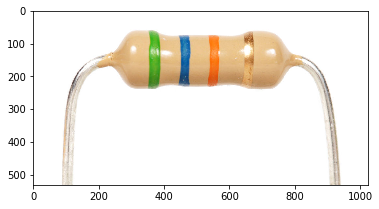

In [3]:
img = cv2.imread("res.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

plt.figure(0)
plt.imshow(img)

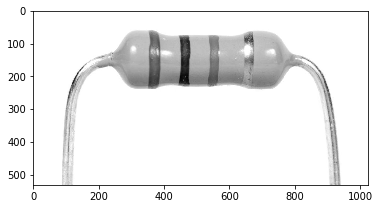

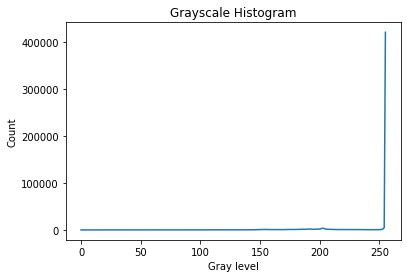

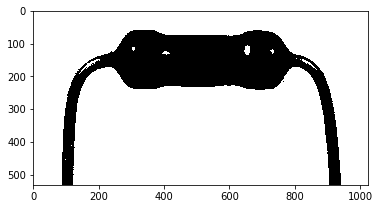

In [4]:
# Grayscale
gray = cv2.imread("res.jpg", cv2.IMREAD_GRAYSCALE)
plt.figure(0)
plt.imshow(gray, cmap='gray')


# Plot histogram
hist = cv2.calcHist([gray],[0],None,[256],[0,256])
plt.figure(1)
plt.plot(hist) 
plt.title("Grayscale Histogram")
plt.xlabel("Gray level")
plt.ylabel("Count")
plt.show()


# Binarize image by thresholding
threshold = 250
bin_img = gray.copy()
bin_img[bin_img < threshold] = 0
bin_img[bin_img >= threshold] = 255

plt.figure(2)
plt.imshow(bin_img, cmap='gray')

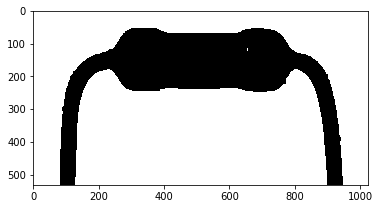

In [5]:
# Mask
kernel = np.ones((5,5), np.uint8) 
mask = cv2.erode(bin_img, kernel, iterations=3) 


plt.figure()
plt.imshow(mask, cmap='gray')


In [6]:
height, width = mask.shape
print(mask[0][0])


def findResistorMeat(mask):
    min_region_size = 100
    black_flag = False
    result = []
    
    # Find top left and right corners
    for i in range(height):
        start = (0,0)
        stop = (0,0)
        black_count = 0

        for j in range(width):
            pixel = mask[i][j]
            
            # Transition from white to black
            if(!black_flag and pixel == 0):
                
                # Check if hit second black region
                if(stop !=(0,0)):
                    break
                
                start = (i,j)
                black_flag = True

            if(black_flag):
                black_count += 1
            
            # Transition from black to white
            if(black_flag and pixel == 255):
                stop = (i,j)
                black_flag = False

        if(black_count >= min_region_size):
            result.append(start)
            result.append(stop)
    
    
    # Find bottom midpoint
        

SyntaxError: invalid syntax (<ipython-input-6-62d4be1847c0>, line 20)

## Color Identification

In [32]:
# Color helper functions

# RGB color definitions
colors = {'red': (255,0,0),
          
          'green': (0,255,0),
          #'green': (68,181,32),
          #'green': (149,213,128),
          
          'blue': (0,0,255),
          'blue': (59,134,180),
          #'blue': (26,86,141),
                    
          'yellow': (255,255,0),
          
          'orange': (255,127,0),
          'orange': (249,110,11),
          
          'white': (255,255,255),
          'black': (0,0,0),
          
          #'gray': (127,127,127),
          #'pink': (255,127,127),
          #'purple': (127,0,255),
          
          'beige': (233,196,141),
          'beige': (215,171,117),
          
          'gold': (217,160,91),
          'gold': (189,125,62),
         }

def distance(left, right):
    return sum((l-r)**2 for l, r in zip(left, right))**0.5

class NearestColorKey(object):
    def __init__(self, goal):
        self.goal = goal
    def __call__(self, item):
        return distance(self.goal, item[1])

def avgPixel(array):
    temp = (0,0,0)
    for p in array:
        temp += p
    
    result = temp // len(array)
    return result


In [33]:
# Test color helpers
result = min(colors.items(), key=NearestColorKey((10,10,100)))
print(result)

result = min(colors.items(), key=NearestColorKey(img[150][10]))
print(result)


('black', (0, 0, 0))
('white', (255, 255, 255))


In [34]:
# Find distance between two colors
def findDistance(color1, color2):
    distance = math.sqrt((color1[0]-color2[0])**2 + (color1[1]-color2[1])**2 + (color1[2]-color2[2])**2)
    return distance

# Find color of a pixel
def findPixelColor(pixel):
    print(pixel)
    pixelColor = ''
    min_dist = math.sqrt(3*(256**2))
    
    for key,value in colors.items():
        dist = findDistance(pixel, value)
        if(dist < min_dist):
            min_dist = dist
            pixelColor = key
    
    print(pixelColor)               
    print(min_dist)
    
    return pixelColor


# Test with blue pixel
findPixelColor(img[95][455])

[ 13 106 175]
blue
54.08326913195984


'blue'

blue


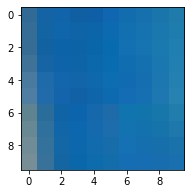

In [35]:
# Find color of a block
def findBlockColor(block):
    h, w, d = block.shape
    
    foundColors = {}
    
    for i in range(h):
        for j in range(w):
            color = min(colors.items(), key=NearestColorKey(block[i][j]))
            color = color[0]
            if(color not in foundColors):
                foundColors[color] = 1
            else:
                foundColors[color] = foundColors[color] + 1
                
    #print(foundColors)
    
    blockColor = max(foundColors)
    #print(blockColor)
    
    return blockColor


# Test with blue block
block = img[90:100, 450:460,:]
plt.figure(figsize=(3,3))
plt.imshow(block)
print(findBlockColor(block))


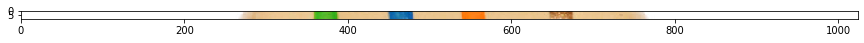

In [36]:
# Extract horizontal slice from picture
copy = img
sliceValue = 90
blockSize = 5

copy = copy[sliceValue: sliceValue+blockSize, :,:]

#plt.figure(0)
plt.figure(figsize=(15,8))
plt.imshow(copy)

In [37]:
# Color identification using blocks - DOES NOT WORK AS WELL
height, width, depth = img.shape
h = sliceValue

foundColorsSet = set()
foundColorsArray = []

i = 0
startFlag = False

while(i + blockSize < width):
    block = img[h:h+blockSize, i:i+blockSize, :]
    color = findBlockColor(block)
    
    if(color == 'beige'):
        startFlag = True
    
    if(startFlag and color != 'white' and color != 'beige'):
        if(color not in foundColorsSet):
            foundColorsSet.add(color)
            foundColorsArray.append(color)
    i += blockSize
    
print("Colors found: ", foundColorsArray)


Colors found:  ['gold', 'green', 'blue', 'orange']


In [16]:
# Color identification using line of pixels
h = sliceValue

line = img[h]
print(line.shape)

#print(line)

foundColorsSet = set()
foundColorsArray = []


i = 0
batchSize = 1
regionSize = 10
startFlag = False
increment = 1

while(i + regionSize < len(line)):
    #print(line[i])
        
    # Moving average
    #pixels = line[i : i+batchSize]
    #pixel = avgPixel(pixels)
    
    # Get current pixel color
    pixel = line[i]
    color = min(colors.items(), key=NearestColorKey(pixel))
    color = color[0]
    
    # Check consistent color sequence of region size
    for x in range(i, i + regionSize):
        pixel = line[x]
        c = min(colors.items(), key=NearestColorKey(pixel))
        c = c[0]
        
        if(color != c):
            color = None
            break
    
    print(i, color)
    
    # If inconsistent color, then move on
    if(color is None):
        i += increment
        continue
        
    #print(color)
    
    if(color == 'beige'):
        startFlag = True
    
    #change: if hit beige, reset color set since we can hit same color band
    
    if(startFlag and color != 'white' and color != 'beige'):
        if(color not in foundColorsSet):
            foundColorsSet.add(color)
            foundColorsArray.append(color)
    i += increment


print("Colors found: ", foundColorsArray)



(1024, 3)
0 white
1 white
2 white
3 white
4 white
5 white
6 white
7 white
8 white
9 white
10 white
11 white
12 white
13 white
14 white
15 white
16 white
17 white
18 white
19 white
20 white
21 white
22 white
23 white
24 white
25 white
26 white
27 white
28 white
29 white
30 white
31 white
32 white
33 white
34 white
35 white
36 white
37 white
38 white
39 white
40 white
41 white
42 white
43 white
44 white
45 white
46 white
47 white
48 white
49 white
50 white
51 white
52 white
53 white
54 white
55 white
56 white
57 white
58 white
59 white
60 white
61 white
62 white
63 white
64 white
65 white
66 white
67 white
68 white
69 white
70 white
71 white
72 white
73 white
74 white
75 white
76 white
77 white
78 white
79 white
80 white
81 white
82 white
83 white
84 white
85 white
86 white
87 white
88 white
89 white
90 white
91 white
92 white
93 white
94 white
95 white
96 white
97 white
98 white
99 white
100 white
101 white
102 white
103 white
104 white
105 white
106 white
107 white
108 white
109 white


860 white
861 white
862 white
863 white
864 white
865 white
866 white
867 white
868 white
869 white
870 white
871 white
872 white
873 white
874 white
875 white
876 white
877 white
878 white
879 white
880 white
881 white
882 white
883 white
884 white
885 white
886 white
887 white
888 white
889 white
890 white
891 white
892 white
893 white
894 white
895 white
896 white
897 white
898 white
899 white
900 white
901 white
902 white
903 white
904 white
905 white
906 white
907 white
908 white
909 white
910 white
911 white
912 white
913 white
914 white
915 white
916 white
917 white
918 white
919 white
920 white
921 white
922 white
923 white
924 white
925 white
926 white
927 white
928 white
929 white
930 white
931 white
932 white
933 white
934 white
935 white
936 white
937 white
938 white
939 white
940 white
941 white
942 white
943 white
944 white
945 white
946 white
947 white
948 white
949 white
950 white
951 white
952 white
953 white
954 white
955 white
956 white
957 white
958 white
959 white


## Calculate Resistance

In [ ]:
colorValues = {
    'black': 0,
    'brown': 1,
    'red': 2,
    'orange': 3,
    'yellow': 4,
    'green': 5,
    'blue': 6,
    'purple': 7,
    'gray': 8,
    'white': 9
}

toleranceValues = {
    'brown': 1,
    'red': 2,
    'green': 0.5,
    'blue': 0.25,
    'purple': 0.1,
    'gray': 0.05,
    'gold': 5,
    'silver': 10,
}


print(foundColorsArray)

values = [colorValues[c] for c in foundColorsArray[:-1]]
print(values)

In [ ]:
# Find resistance from array of ordered colors. Includes tolerance.
def findResistance(foundColorsArray):
    # Extract tolerance
    tolerance_color = foundColorsArray[-1]
    tolerance = toleranceValues[tolerance_color]

    # Calculate resistance
    resistance = 0
    values = [colorValues[c] for c in foundColorsArray[:-1]]
    
    numBands = len(values)

    if(numBands == 3):    
        resistance = (values[0]*10 + values[1]) * (10 ** values[2])
    
    elif(numBands == 4):
        resistance = (values[0]*100 + values[1]*10 + values[2]) * (10 ** values[3])

    
    return resistance, tolerance

res, tol = findResistance(foundColorsArray)
print("Resistance =", res, "+-", (str(tol) + "%"), "ohms")